 Что такое диаграмма Вороного?



 Диаграмма Вороного делит плоскость на отдельные области,

 где каждая область содержит ровно одну генерирующую точку (seed),

 и каждая точка в данной области ближе к своему seed, чем к любому другому.

 Области на краях кластера точек простираются в бесконечность

In [1]:
import cv2
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib import pyplot as plt


from skimage import filters
from skimage.feature import local_binary_pattern, peak_local_max

In [2]:
PICTURES_PATH = 'materials/imgs/'

In [3]:
class Shower:
    def show_img(
        img_mtx: np.ndarray, 
        extra_img_params: dict = {}, 
        in_gray: bool=True, 
        is_show: bool=True,
        figsize: tuple=None
    ):
        '''
            cmap='gray': display the image in grayscale
        '''
        
        if in_gray:
            img_params = {'X': img_mtx} | {'cmap':'gray'} | extra_img_params
        else:
            img_params ={'X': img_mtx} | extra_img_params

            
        if figsize is not None:
            plt.figure(figsize=figsize)
        

        plt.imshow(**img_params)
        plt.axis('off')


        if is_show:
            plt.show()


    def show_two_img(
        img_mtx1: np.ndarray, 
        img_mtx2: np.ndarray,
        title_img1: str = None,
        title_img2: str = None,
        extra_img1_params: dict = {},
        extra_img2_params: dict = {},
        figsize: tuple=(8, 12)
    ):
        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        Shower.show_img(img_mtx1, extra_img1_params, is_show=False)
        if title_img1:
            plt.title(title_img1)

        plt.subplot(1, 2, 2)
        Shower.show_img(img_mtx2, extra_img2_params, is_show=False)
        if title_img2:
            plt.title(title_img2)

        plt.tight_layout() # fit into the figure area without overlapping
        plt.show()




 # 1. Пример работы алгоритма на заранее заданных точках

[[0.5 0.5]
 [0.5 1.5]
 [1.5 0.5]
 [1.5 1.5]]
[[], [-1, 0], [-1, 1], [1, -1, 0], [3, -1, 2], [-1, 3], [-1, 2], [0, 1, 3, 2], [2, -1, 0], [3, -1, 1]]


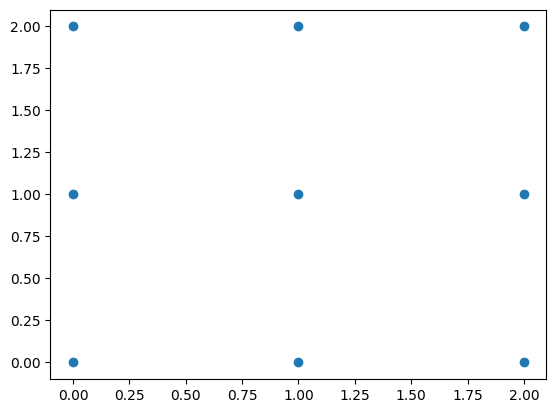

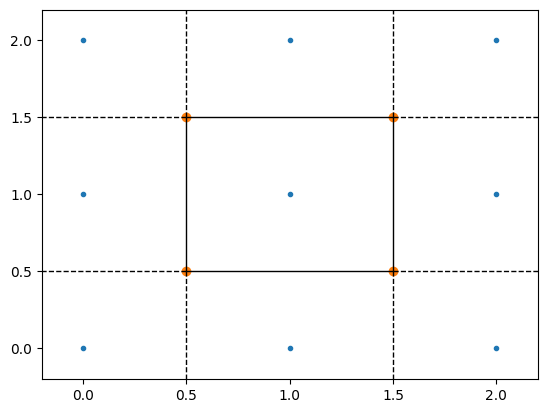

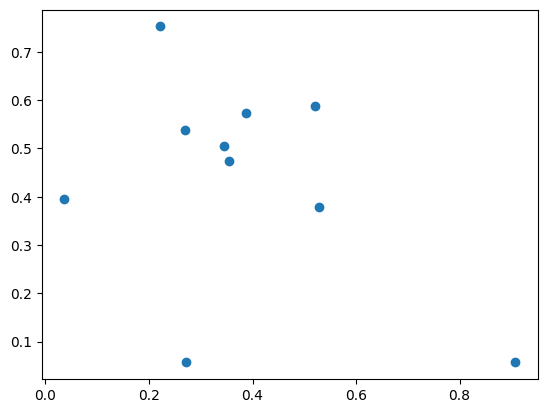

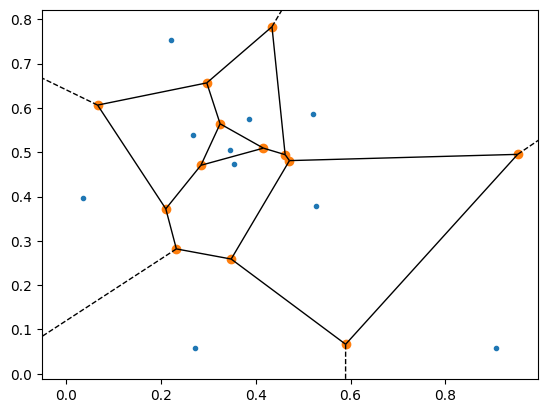

In [4]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

plt.scatter(points[:, 0], points[:, 1])

# Создание объекта Вороного
vor = Voronoi(points)

# Получение вершин диаграммы Вороного
vor_vertices = vor.vertices
print(vor_vertices)

# Получение областей диаграммы Вороного
vor_regions = vor.regions
print(vor_regions)  # Каждый подсписок содержит координаты областей

# Использование встроенной функции для построения диаграммы
fig = voronoi_plot_2d(vor)
plt.show()

# Генерация случайных координат
coords = np.random.rand(10, 2)
vor2 = Voronoi(coords)

plt.scatter(coords[:, 0], coords[:, 1])

fig2 = voronoi_plot_2d(vor2)
plt.show()


 Как диаграмма Вороного может помочь в сегментации изображений?

 Что если мы найдем центры объектов и используем их в качестве точек (seed) для Вороного?

 Затем сегментируем объекты, используя пороговое значение в каждой области Вороного?

 Это простой способ сегментации объектов.

 # 2. Пример работы алгоритма диаграмм Вороного на изображении микроорганизмов

In [5]:
PICTURE1_PATH = PICTURES_PATH + 'temp.jpg'


In [6]:
target_img = cv2.cvtColor(cv2.imread(PICTURE1_PATH), cv2.COLOR_BGR2RGB)

# Проверка размеров изображения
target_img.shape

(598, 596, 3)

(598, 596)


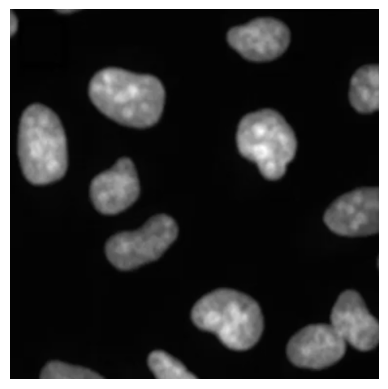

In [7]:
# отбираем только один цветовой канал для корректной работы (третий индекс 0 соотвествует первому по порядку каналу)
img = target_img[:, :, 0]
print(img.shape)

Shower.show_img(img)


In [8]:
from scipy import ndimage

def filters_gaussian(image, sigma=5):
    # Создание ядра/фильтра (гауссовский фильтр)
    filter_size = (50, 50)  # Размер фильтра (ширина, высота)
    size_y = filter_size[0] // 2  # Половина высоты фильтра
    size_x = filter_size[1] // 2  # Половина ширины фильтра

    # Создание сетки координат для ядра фильтра
    x, y = np.mgrid[-size_y:size_y+1, -size_x:size_x+1]  # Массивы координат x и y
    normal = 1 / (2.0 * np.pi * sigma**2)  # Нормализующий коэффициент
    gaussian_filter = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal  # Формула для гауссовского фильтра

    # Применение свёртки (размытие изображения)
    filtered = ndimage.convolve(image, gaussian_filter)  # Свёртка изображения с гауссовским фильтром
    filtered = filtered.astype('uint8')  # Приведение к целочисленному типу для отображения

    return filtered


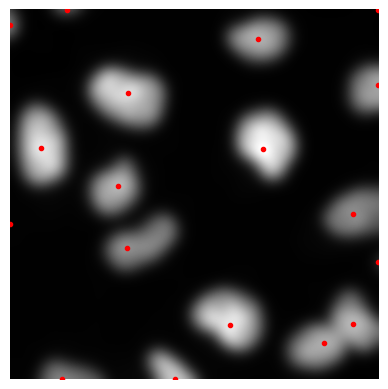

In [9]:
# Шаг 1 - Применение гауссового размытия для усреднения локальных вариаций интенсивности
img_blurred = filters.gaussian(img, sigma=11)  # Гауссовое размытие с заданным значением sigma
# (с уменьшением sigma красных точек становится больше)
plt.imshow(img_blurred, cmap='gray')  # Отображение размытого изображения
plt.axis('off')  # Убираем оси для более чистого отображения

# Шаг 2: Нахождение точек, представляющих каждый объект, для использования в Вороного
# Нахождение локальных максимумов на изображении
coordinates = peak_local_max(
    img_blurred,
    min_distance=20,
    exclude_border=False
)


# Отображение результатов
Shower.show_img(
    img_blurred,
    is_show=False
)
# Рисование точек локальных максимумов
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

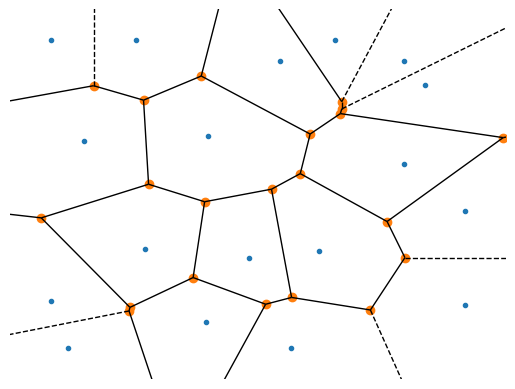

In [10]:
# Шаг 3: Создание диаграммы вороного
vor3 = Voronoi(coordinates)

fig3 = voronoi_plot_2d(vor3)
plt.axis('off')
plt.show()
# Обратите внимание, что изображение повернуто один раз против часовой стрелки


 ## ДЗ часть 1: Последовательное использование медотов для получения диаграммы Воронова

 Соберите указанный выше код в один метод, который на вход будет принимать путь к картинке в папке colab и возвращать диаграммы Вороного

In [11]:
def voronoi_pipline(img_path: str, is_show_steps: bool=True):
    target_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = target_img[:, :, 0]

    # Шаг 1 - Применение гауссового размытия для усреднения локальных вариаций интенсивности
    img_blurred = filters.gaussian(img, sigma=11)  # Гауссовое размытие с заданным значением sigma (с уменьшением sigma красных точек становится больше)

    # Шаг 2: Нахождение точек, представляющих каждый объект, для использования в Вороного
    # Нахождение локальных максимумов на изображении
    coordinates = peak_local_max(
        img_blurred,
        min_distance=20,
        exclude_border=False
    )

    if is_show_steps:
        # Отображение результатов
        Shower.show_img(
            img_blurred,
            is_show=False
        )
        # Рисование точек локальных максимумов
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

    # Шаг 3: Создание диаграммы вороного
    vor3 = Voronoi(coordinates)

    return vor3


In [12]:
# Путь к изображению
PICTURE2_PATH = PICTURES_PATH + 'leopard.JPG'

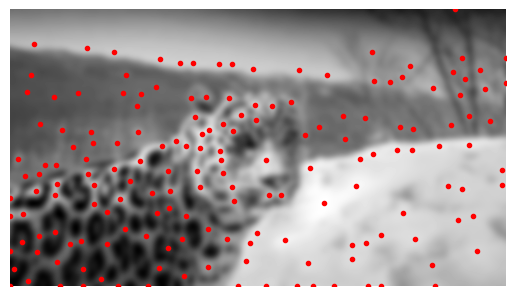

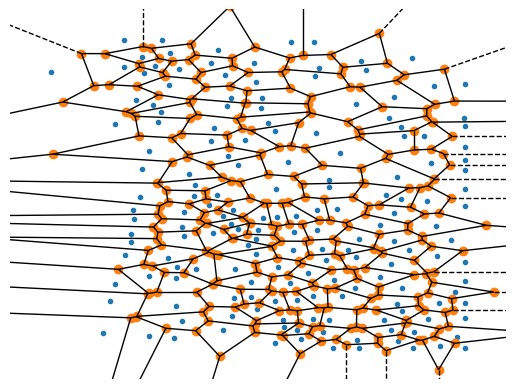

In [13]:
vor3 = voronoi_pipline(PICTURE2_PATH)
fig3 = voronoi_plot_2d(vor3)
plt.axis('off')
plt.show()


 # 3. Пример использования локальных бинарных шаблонов

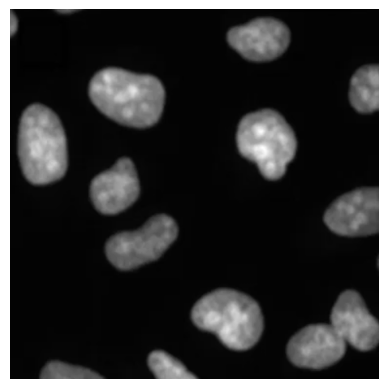

In [14]:
# Загружаем изображение и преобразуем его в оттенки серого
image = cv2.imread(PICTURE1_PATH, cv2.IMREAD_GRAYSCALE)
Shower.show_img(image)


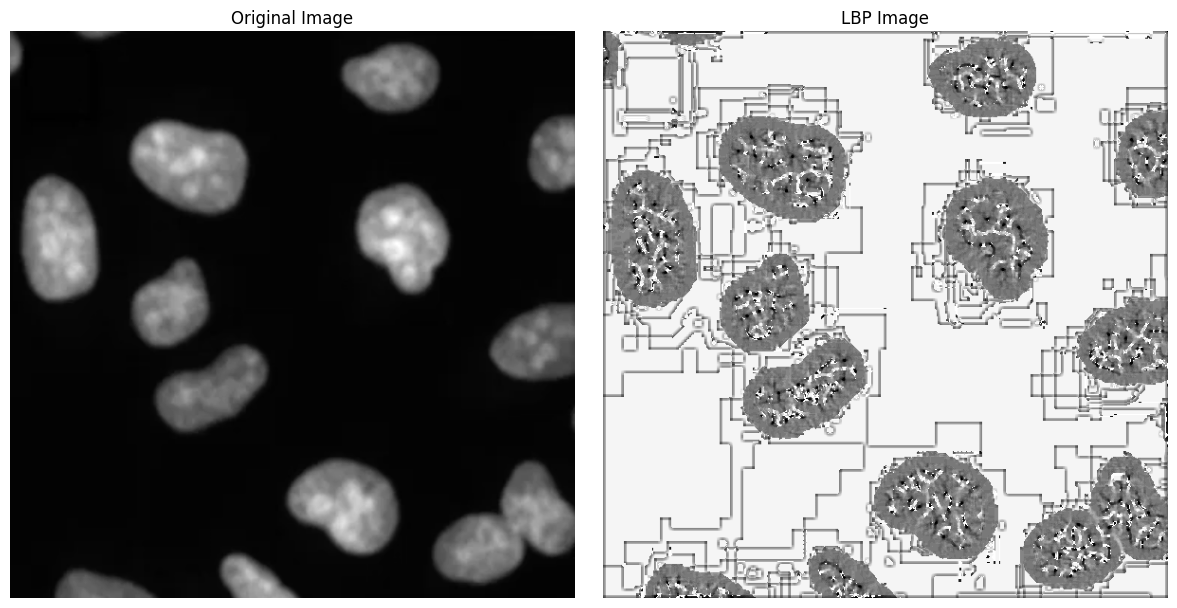

LBP Histogram: [0.00243261 0.00111109 0.00158526 0.00174239 0.00215483 0.00292923
 0.00310038 0.0063663  0.01055251 0.01674485 0.02601232 0.05589661
 0.07255168 0.0671169  0.01828522 0.03720175 0.01083028 0.03348971
 0.00856322 0.00740163 0.00565924 0.00637752 0.00475859 0.00292642
 0.57019483 0.02401461]


In [15]:
# Параметры LBP
radius = 3  # Радиус для поиска соседних пикселей
n_points = 8 * radius  # Количество точек по окружности

# Применение LBP к изображению
lbp = local_binary_pattern(image, n_points, radius, method="uniform")

# Построение гистограммы LBP для всего изображения
# Уникальные значения и их частоты (гистограмма)
lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

# Нормализуем гистограмму
lbp_hist = lbp_hist.astype("float")
lbp_hist /= (lbp_hist.sum() + 1e-6)

# Отображаем исходное изображение и его LBP
Shower.show_two_img(
    image,
    lbp,
    title_img1 = 'Original Image',
    title_img2 = 'LBP Image',
    figsize = (12, 6)
)

print("LBP Histogram:", lbp_hist)


 ## ДЗ часть 2: Последовательное использование медотов

 Соберите указанный выше код в один метод, который на вход будет принимать путь к картинке в папке colab и возвращать результат операции определения локальных бинарных шаблонов

In [16]:
PICTURE3_PATH = PICTURES_PATH + 'brick_wall.jpg'


In [17]:
def local_binary_pattern_pipline(img, radius=3, n_points=8):
    # Применение LBP к изображению
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")

    # Построение гистограммы LBP для всего изображения
    # Уникальные значения и их частоты (гистограмма)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Нормализуем гистограмму
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    return lbp


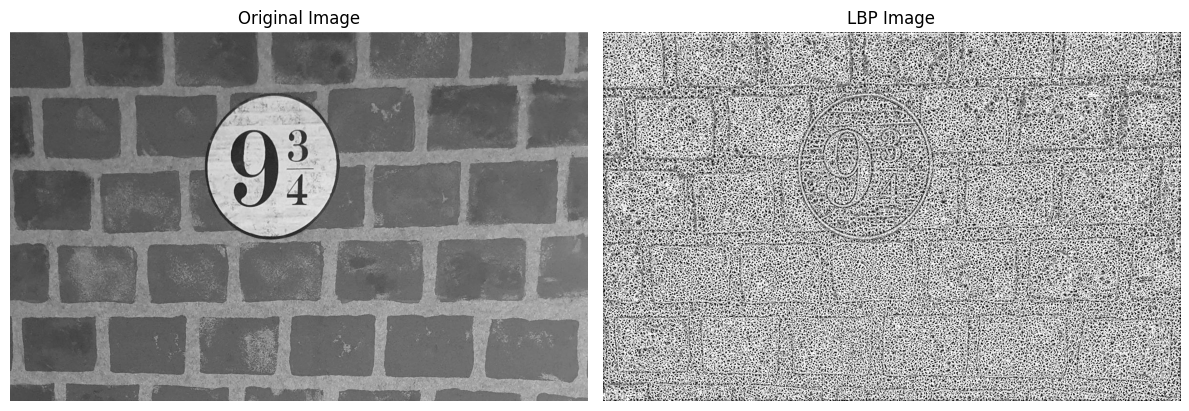

LBP Histogram: [0.00243261 0.00111109 0.00158526 0.00174239 0.00215483 0.00292923
 0.00310038 0.0063663  0.01055251 0.01674485 0.02601232 0.05589661
 0.07255168 0.0671169  0.01828522 0.03720175 0.01083028 0.03348971
 0.00856322 0.00740163 0.00565924 0.00637752 0.00475859 0.00292642
 0.57019483 0.02401461]


In [18]:
# Загружаем изображение и преобразуем его в оттенки серого
image = cv2.imread(PICTURE3_PATH, cv2.IMREAD_GRAYSCALE)

lbp = local_binary_pattern_pipline(image)

# Отображаем исходное изображение и его LBP
Shower.show_two_img(
    image,
    lbp,
    title_img1 = 'Original Image',
    title_img2 = 'LBP Image',
    figsize = (12, 6)
)

print("LBP Histogram:", lbp_hist)


 # 4. Пример из библиотеки scikit-image для общего развития

 Документация: https://scikit-image.org/docs/0.24.x/auto_examples/features_detection/plot_local_binary_pattern.html

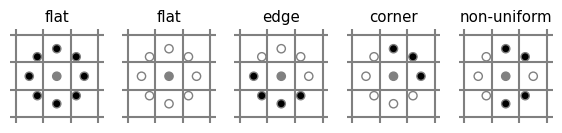

In [19]:
import numpy as np
import matplotlib.pyplot as plt


METHOD = 'uniform'
plt.rcParams['font.size'] = 9


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [
    np.zeros(8),
    np.ones(8),
    np.hstack([np.ones(4), np.zeros(4)]),
    np.hstack([np.zeros(3), np.ones(5)]),
    [1, 0, 0, 1, 1, 1, 0, 0],
]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)


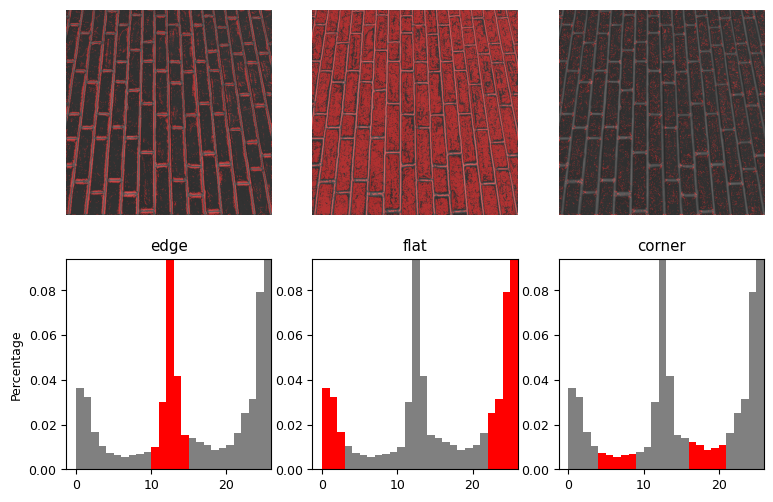

In [20]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.brick()
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(
        lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5'
    )


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4  # 1/4th of the histogram
i_34 = 3 * (n_points // 4)  # 3/4th of the histogram
corner_labels = list(range(i_14 - w, i_14 + w + 1)) + list(
    range(i_34 - w, i_34 + w + 1)
)

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')